In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random
import operator
import math
import heapq
import itertools
import multiprocessing as mp
import datetime
import time
import threading
import queue
import networkx as nx

In [ ]:
pip install scipy==1.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df = pd.read_csv('star-wars-network-edges.csv')

In [ ]:
df1 = df[['source', 'target','weight']]

In [ ]:
G = nx.from_pandas_edgelist(df1,'source','target')

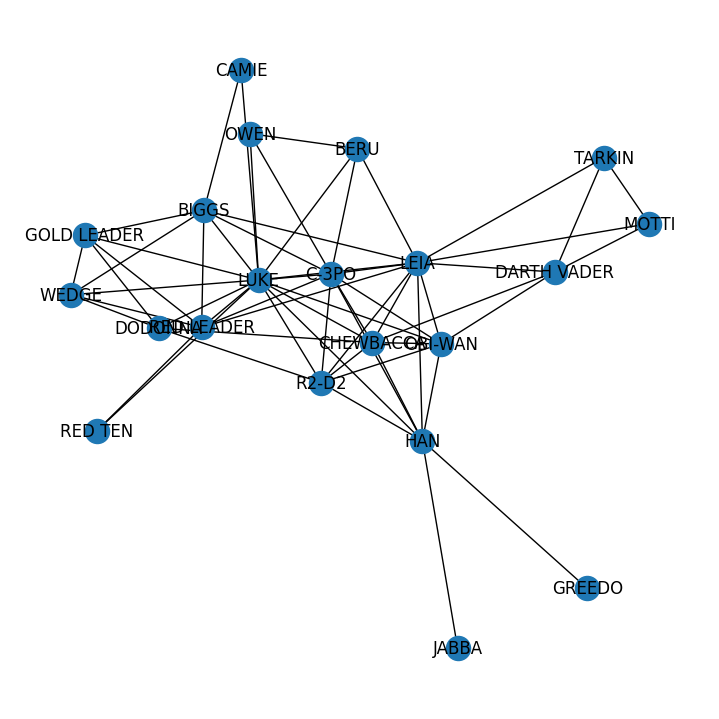

In [ ]:
figure(figsize=(7, 7))
nx.draw(G,with_labels = True)

In [ ]:

# Define the distance metric (in this case, shortest path distance)
def distance(node1, node2):
    return len(nx.shortest_path(G, node1, node2))

# Define the canopy clustering algorithm
def canopy_clustering(graph, t1, t2):
    # Initialize empty list of canopies
    canopies = []
    # Define a list of nodes to choose from
    nodes = list(graph.nodes())
    while nodes:
        # Choose a random node as a center node
        center_node = np.random.choice(nodes)
        
        # Find all nodes within distance t1 of the center node
        canopy_nodes = [n for n in nodes if distance(center_node, n) <= t1]
        
        # Add the canopy to the list of canopies
        canopies.append(canopy_nodes)
        # Remove the canopy nodes from the list of nodes
        nodes = [n for n in nodes if n not in canopy_nodes]
        
        # Remove all nodes within distance t2 of the center node
        nodes = [n for n in nodes if distance(center_node, n) > t2]
        
    return canopies

# Test the algorithm with t1 = 2 and t2 = 1
start = time.time()
canopies = canopy_clustering(G, t1=2, t2=1)
end = time.time()
print("Total time : "+ (end-start))
print("Canopies:", canopies)

Canopies: [['LEIA', 'DARTH VADER', 'MOTTI', 'TARKIN'], ['R2-D2', 'LUKE', 'CHEWBACCA', 'DODONNA', 'GOLD LEADER', 'WEDGE'], ['C-3PO', 'BERU', 'OWEN'], ['HAN', 'GREEDO'], ['RED LEADER', 'RED TEN'], ['JABBA'], ['OBI-WAN'], ['CAMIE', 'BIGGS']]


In [ ]:
subgraphs = []
for component in canopies:
  temp = nx.Graph()
  temp = G.subgraph(component)
  subgraphs.append(temp)

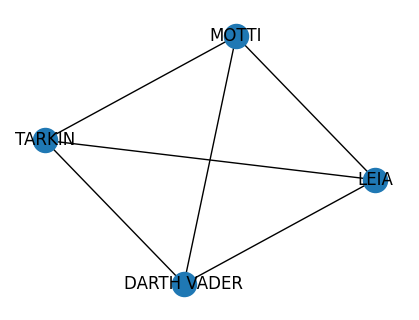

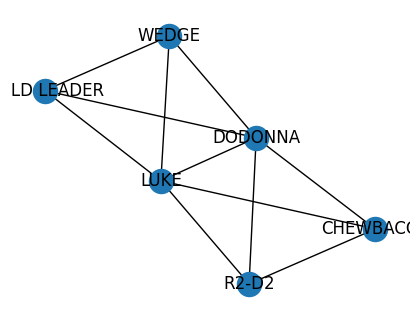

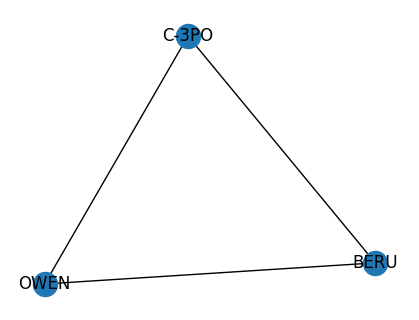

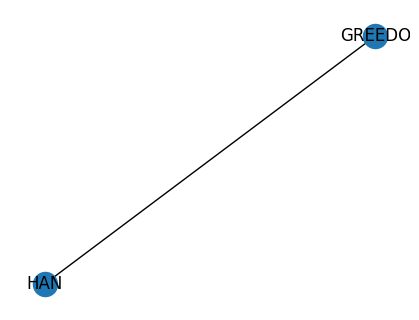

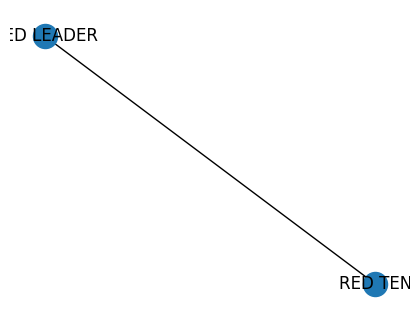

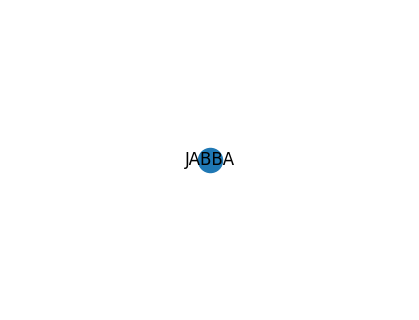

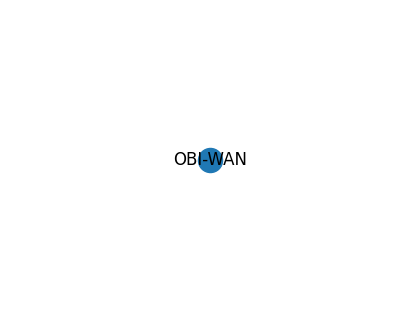

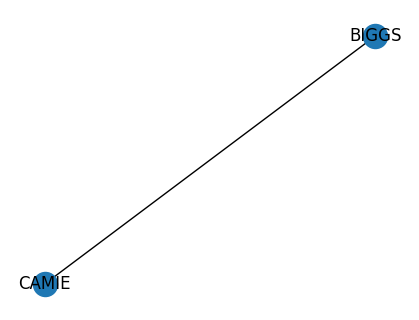

In [ ]:
for graph in subgraphs:
  figure(figsize=(4, 3))
  nx.draw(graph,with_labels = True)


In [ ]:
def calculate_edge_betweenness_centrality(subgraph):
    betweenness = {}
    for node in subgraph.nodes():
        stack = []
        pred = {w: [] for w in subgraph.nodes()}
        sigma = {w: 0 for w in subgraph.nodes()}
        distance = {w: -1 for w in subgraph.nodes()}
        sigma[node] = 1
        distance[node] = 0
        queue = [node]
        while queue:
            v = queue.pop(0)
            stack.append(v)
            for w in subgraph.neighbors(v):
                if distance[w] < 0:
                    queue.append(w)
                    distance[w] = distance[v] + 1
                if distance[w] == distance[v] + 1:
                    sigma[w] += sigma[v]
                    pred[w].append(v)
        delta = {v: 0 for v in subgraph.nodes()}
        while stack:
            w = stack.pop()
            for v in pred[w]:
                delta[v] += (sigma[v]/sigma[w]) * (1 + delta[w])
                if (v, w) in betweenness:
                    betweenness[(v, w)] += delta[v]
                elif (w, v) in betweenness:
                    betweenness[(w, v)] += delta[v]
                else:
                    betweenness[(v, w)] = delta[v]
    return betweenness

In [ ]:


def calculate_edge_betweenness_centrality_mt(G, sources, q):
    # Initialize variables
    betweenness = {e: 0 for e in G.edges()}
    stack = []
    sigma = {v: 0 for v in G.nodes()}
    distance = {v: -1 for v in G.nodes()}
    distance.update({v: 0 for v in sources})
    sigma.update({v: 1 for v in sources})
    
    # Breadth-first search
    queue = sources[:]
    while queue:
        v = queue.pop(0)
        stack.append(v)
        for w in G.neighbors(v):
            if distance[w] < 0:
                queue.append(w)
                distance[w] = distance[v] + 1
            if distance[w] == distance[v] + 1:
                sigma[w] += sigma[v]
    
    # Calculate betweenness
    delta = {v: 0 for v in G.nodes()}
    while stack:
        w = stack.pop()
        for v in G.neighbors(w):
            if distance[v] == distance[w] - 1:
                delta[v] += (sigma[v] / sigma[w]) * (1 + delta[w])
                if (v, w) in betweenness:
                    betweenness[(v, w)] += delta[v]
                else:
                    betweenness[(w, v)] += delta[v]
    
    # Add results to queue
    q.put(betweenness)

def calculate_edge_betweenness_centrality_parallel(G, n_threads=4):
    betweenness = {e: 0 for e in G.edges()}
    threads = []
    q = queue.Queue()
    sources = list(G.nodes())
    
    # Start threads
    for i in range(n_threads):
        t = threading.Thread(target=calculate_edge_betweenness_centrality_mt, args=(G, sources[i::n_threads], q))
        threads.append(t)
        t.start()
    
    # Wait for threads to finish and combine results
    for t in threads:
        t.join()
    
    while not q.empty():
        b = q.get()
        for e in b:
            betweenness[e] += b[e]
    
    return betweenness


In [ ]:
k=15

In [ ]:
comp_budget = {}
sg_budget = []

for graph in subgraphs:
  comp_budget[graph] = 0.5 * len(graph.nodes) + 0.5 * len(graph.edges)
sum = 0

for ind in comp_budget.values():
  sum += ind

result = {key: round(value * k / sum) for key, value in comp_budget.items()}  

i = 1
for j in result.values():
  print(i,"th component budget : ",j)
  i = i + 1
  sg_budget.append(j)

1 th component budget :  3
2 th component budget :  6
3 th component budget :  2
4 th component budget :  1
5 th component budget :  1
6 th component budget :  0
7 th component budget :  0
8 th component budget :  1


In [ ]:
G2 = G.copy()

In [ ]:
def mapper(subgraph,num):
    betweenness = calculate_edge_betweenness_centrality(subgraph)
    sorted_edge_bc = dict( sorted(betweenness.items(), key=operator.itemgetter(1),reverse=True))
    sorted_edge_bc2 = dict(itertools.islice(sorted_edge_bc.items(), num))
    return sorted_edge_bc2

def reducer(results):
    betweenness = {}
    for result in results:
        for e in result:
            betweenness[e] = result[e]
    return betweenness


In [ ]:
start = time.time()
all_sub_graphs = [graph for graph in subgraphs]
pool = mp.Pool(processes=4)
results = pool.starmap(mapper, zip(all_sub_graphs,sg_budget))
edge_list = reducer(results)
end = time.time()
print(edge_list)

{('TARKIN', 'MOTTI'): 6.0, ('LEIA', 'DARTH VADER'): 6.0, ('DARTH VADER', 'MOTTI'): 4.0, ('LUKE', 'R2-D2'): 12.0, ('DODONNA', 'GOLD LEADER'): 10.0, ('LUKE', 'CHEWBACCA'): 9.0, ('R2-D2', 'DODONNA'): 9.0, ('DODONNA', 'WEDGE'): 8.0, ('CHEWBACCA', 'R2-D2'): 8.0, ('BERU', 'OWEN'): 4.0, ('C-3PO', 'BERU'): 3.0, ('HAN', 'GREEDO'): 2.0, ('RED LEADER', 'RED TEN'): 2.0, ('BIGGS', 'CAMIE'): 2.0}


In [ ]:
print("Time for computation without multithreading in mappers",end-start)

Time for computation without multithreading in mappers 0.06241440773010254


In [ ]:
removable_edges = []
for key in edge_list.keys():
  removable_edges.append(key)
print(removable_edges)

[('TARKIN', 'MOTTI'), ('LEIA', 'DARTH VADER'), ('DARTH VADER', 'MOTTI'), ('LUKE', 'R2-D2'), ('DODONNA', 'GOLD LEADER'), ('LUKE', 'CHEWBACCA'), ('R2-D2', 'DODONNA'), ('DODONNA', 'WEDGE'), ('CHEWBACCA', 'R2-D2'), ('BERU', 'OWEN'), ('C-3PO', 'BERU'), ('HAN', 'GREEDO'), ('RED LEADER', 'RED TEN'), ('BIGGS', 'CAMIE')]


In [ ]:
for edge in removable_edges:
  G.remove_edge(edge[0],edge[1])

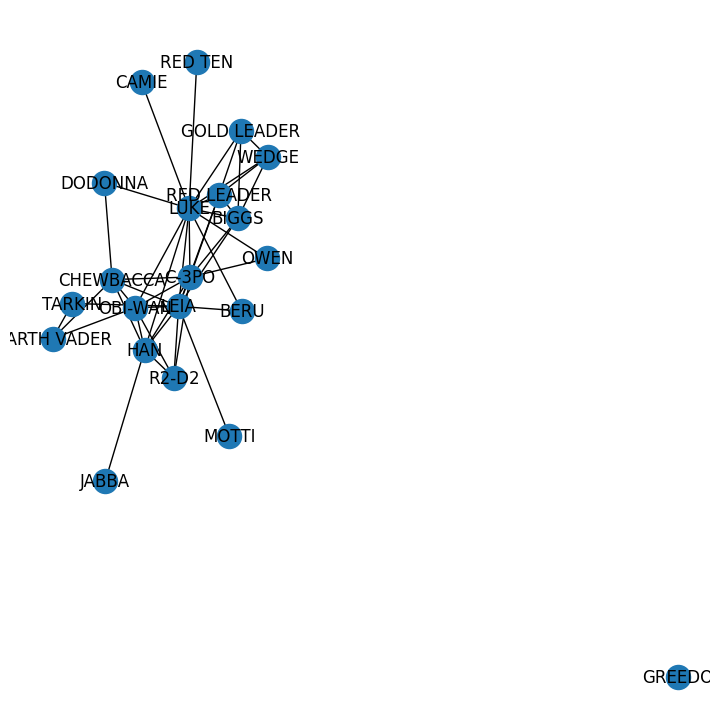

In [ ]:
figure(figsize=(7, 7))
nx.draw(G,with_labels = True)

In [ ]:
print(G.number_of_edges())

46


In [ ]:
from numpy.linalg import matrix_rank,eig

In [ ]:
def Connectivity(graph):
  A = nx.adjacency_matrix(graph)
  r = matrix_rank(A.todense())
  vals,v = eig(A.todense())
  # vals = nx.adjacency_spectrum(graph)
  sorted(vals,reverse = True)
  vals = vals[:r]
  # Using natural connectivity as the connectivity measure
  sum = 0
  for val in vals:
    sum += math.exp(val)
  nc = sum/len(vals)
  return nc

In [ ]:
print(Connectivity(G))

44.88470407963385
